# **Amazon Electronic Product Recommendation System**

# **Summary**
This notebook presents a comprehensive analysis and development of a recommendation system for Amazon electronic products, utilizing a large-scale dataset of 7.8 million rows. The project begins with exploratory data analysis and strategic data reduction to address computational constraints. A multi-model approach is implemented, comparing a rank-based system, collaborative filtering methods (user-user and item-item), model-based matrix factorization (SVD), and Neural Collaborative Filtering. Hyperparameter tuning with GridSearchCV and Optuna optimizes model performance, which is evaluated using metrics such as RMSE, Precision@k, and F1-score.

## **Prerequisites**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from collections import defaultdict

from surprise import accuracy
from surprise.reader import Reader
from surprise.dataset import Dataset
from surprise.model_selection import GridSearchCV
from surprise.model_selection import train_test_split
from surprise.prediction_algorithms.knns import KNNBasic
from surprise.prediction_algorithms.matrix_factorization import SVD
from surprise.model_selection import KFold
from surprise import CoClustering

In [ ]:
data = pd.read_csv("ratings_Electronics.csv")

In [7]:
data.columns = ['user_id', 'prod_id', 'rating', 'timestamp']
data = data.drop('timestamp', axis = 1)
df = data.copy()
df.head()

,user_id,prod_id,rating
0,A2CX7LUOHB2NDG,0321732944,5.0
1,A2NWSAGRHCP8N5,0439886341,1.0
2,A2WNBOD3WNDNKT,0439886341,3.0
3,A1GI0U4ZRJA8WN,0439886341,1.0
4,A1QGNMC6O1VW39,0511189877,5.0


As this dataset is very large and has 7,824,482 observations, it is not computationally possible to build a model using this. Moreover, many users have only rated a few products and also some products are rated by very few users. Hence, we can reduce the dataset by considering certain logical assumptions. Here, we will be taking users who have given at least 50 ratings, and the products that have at least 5 ratings, as when we shop online we prefer to have some number of ratings of a product.

In [8]:
users = df.user_id

ratings_count = dict()

for user in users:

    if user in ratings_count:
        ratings_count[user] += 1

    else:
        ratings_count[user] = 1

In [9]:
# We want our users to have at least 50 ratings to be considered
RATINGS_CUTOFF = 50

remove_users = []

for user, num_ratings in ratings_count.items():
    if num_ratings < RATINGS_CUTOFF:
        remove_users.append(user)

df = df.loc[ ~ df.user_id.isin(remove_users)]

In [10]:
prods = df.prod_id

ratings_count = dict()

for prod in prods:

    if prod in ratings_count:
        ratings_count[prod] += 1

    else:
        ratings_count[prod] = 1

In [11]:
# We want our item to have at least 5 ratings to be considered
RATINGS_CUTOFF = 5

remove_users = []

for user, num_ratings in ratings_count.items():
    if num_ratings < RATINGS_CUTOFF:
        remove_users.append(user)

df_final = df.loc[~ df.prod_id.isin(remove_users)]

In [12]:
df_final.head()

,user_id,prod_id,rating
1309,A3LDPF5FMB782Z,1400501466,5.0
1321,A1A5KUIIIHFF4U,1400501466,1.0
1334,A2XIOXRRYX0KZY,1400501466,3.0
1450,AW3LX47IHPFRL,1400501466,5.0
1455,A1E3OB6QMBKRYZ,1400501466,1.0


## **Exploratory Data Analysis**

In [ ]:
df_final.shape

(65290, 3)

**Observations:**
* After reducing the dataset to users who have given at least 50 ratings, and the products with at least 5 ratings, we have 65,290 observations and 3 columns containing user and product id and ratings.

In [ ]:
# Check Data types and provide observations
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 65290 entries, 1309 to 7824426
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   user_id  65290 non-null  object 
 1   prod_id  65290 non-null  object 
 2   rating   65290 non-null  float64
dtypes: float64(1), object(2)
memory usage: 2.0+ MB


In [ ]:
# Check for missing values present and provide observations
df_final.isnull().sum()

user_id    0
prod_id    0
rating     0
dtype: int64

**Observations:**
* There are no null values.
* Both user id and product id have data type of objects.
* Ratings data type is numeric.


In [ ]:
df_final['rating'].describe()

count    65290.000000
mean         4.294808
std          0.988915
min          1.000000
25%          4.000000
50%          5.000000
75%          5.000000
max          5.000000
Name: rating, dtype: float64

**Observations:**
* The dataset's average rating is approximately 4.3, with relatively low variability, evident from the narrow standard deviation of 0.99.
* The distribution of ratings is heavily skewed towards highest rating of 5.


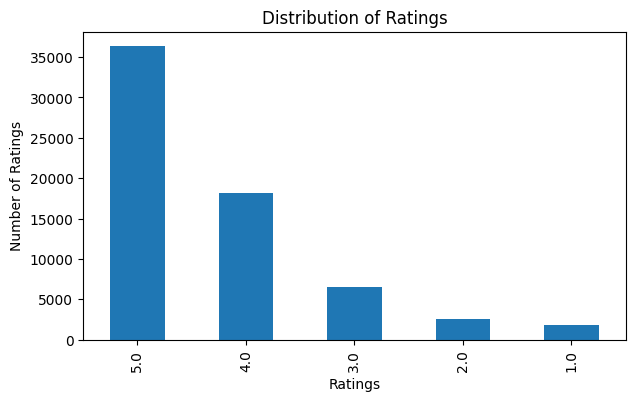

In [ ]:
# Rating distribution
plt.figure(figsize = (7, 4))
df_final['rating'].value_counts().plot(kind = 'bar')

plt.title("Distribution of Ratings")
plt.xlabel("Ratings")
plt.ylabel("Number of Ratings")
plt.show()

**Observations:**
* As per the barplot, rating of 5 has the highest count of rating, around 35000.
* Rating 1 and 2 has lowest count both less than 5000.

In [ ]:
#  The number of unique users and items in the dataset
obs = len(df_final)
user_unique = df_final['user_id'].nunique()
prod_unique = df_final['prod_id'].nunique()
print(obs, user_unique, prod_unique)

65290 1540 5689


**Observations:**
* There are 1540 unique users and 5689 unique products in the dataset.
* There are total of 65,290 of rows/observations in the dataset.
* As per the number of unique users and products, there is a possibility of 1540 * 5689 = 8,761,060 ratings in the dataset. But we only have 65,290 ratings in other words not every user has rated every product in the dataset.


In [ ]:
# Top 10 users based on the number of ratings
most_rated = df_final.groupby('user_id').size().sort_values(ascending = False)[:10]
most_rated

user_id
ADLVFFE4VBT8      295
A3OXHLG6DIBRW8    230
A1ODOGXEYECQQ8    217
A36K2N527TXXJN    212
A25C2M3QF9G7OQ    203
A680RUE1FDO8B     196
A22CW0ZHY3NJH8    193
A1UQBFCERIP7VJ    193
AWPODHOB4GFWL     184
A3LGT6UZL99IW1    179
dtype: int64

**Observations:**
* The highest number of rating by a user is 295 which is way off compared to number of products (5689) in the dataset.

## **Model 1: Rank Based Recommendation System**

In [ ]:
# Calculate the average rating for each product
avg_rating = df_final.groupby('prod_id')['rating'].mean()

# Calculate the count of ratings for each product
count_rating = df_final.groupby('prod_id')['rating'].count()

# Create a dataframe with calculated average and count of ratings
final_rating = pd.DataFrame({
    'average_rating' : avg_rating,
    'rating_count' : count_rating
})

final_rating = final_rating.sort_values(by = 'average_rating', ascending = False)

final_rating.head()

,average_rating,rating_count
prod_id,,
B00LGQ6HL8,5.0,5
B003DZJQQI,5.0,14
B005FDXF2C,5.0,7
B00I6CVPVC,5.0,7
B00B9KOCYA,5.0,8


In [ ]:
# Defining a function to get the top n products based on the highest average rating and minimum interactions
def top_n_recoms (data, n, min_interaction):

  # Finding products with minimum number of interactions
  recom = data[data.rating_count > min_interaction]

  recom = recom.sort_values(by = 'average_rating', ascending = False)

  return recom.index[:n]


In [ ]:
# Recommending top 5 products with 50 minimum interactions based on popularity
list(top_n_recoms(final_rating, 5, 50))

['B001TH7GUU', 'B003ES5ZUU', 'B0019EHU8G', 'B006W8U2MU', 'B000QUUFRW']

In [ ]:
# Recommending top 5 products with 100 minimum interactions based on popularity
list(top_n_recoms(final_rating, 5, 100))

['B003ES5ZUU', 'B000N99BBC', 'B007WTAJTO', 'B002V88HFE', 'B004CLYEDC']

We have recommended the **top 5** products by using the popularity recommendation system. Now, let's build a recommendation system using **collaborative filtering.**

## **Model 2: Collaborative Filtering Recommendation System**

### **Building a baseline user-user similarity based recommendation system**

- Below, we are building similarity-based recommendation systems using `cosine` similarity and using KNN to find similar users which are the nearest neighbor to the given user.  
- We will be using a new library, called `surprise`, to build the remaining models. Let's first import the necessary classes and functions from this library.

**Precision@k** - It is the fraction of recommended items that are relevant in `top k` predictions. The value of k is the number of recommendations to be provided to the user. One can choose a variable number of recommendations to be given to a unique user.  


**Recall@k** - It is the fraction of relevant items that are recommended to the user in `top k` predictions.

**F1-score@k** - It is the harmonic mean of Precision@k and Recall@k**. When precision@k and recall@k both seem to be important then it is useful to use this metric because it is representative of both of them.

In [ ]:
def precision_recall_at_k(model, k = 10, threshold = 3.5):
    """Return precision and recall at k metrics for each user"""

    # First map the predictions to each user
    user_est_true = defaultdict(list)

    # Making predictions on the test data
    predictions = model.test(testset)

    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():
        user_ratings.sort(key = lambda x: x[0], reverse = True)
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    precision = round((sum(prec for prec in precisions.values()) / len(precisions)), 3)
    recall = round((sum(rec for rec in recalls.values()) / len(recalls)), 3)
    accuracy.rmse(predictions)
    print('Precision: ', precision) 
    print('Recall: ', recall) 
    print('F_1 score: ', round((2*precision*recall)/(precision+recall), 3)) 

In [ ]:
# Instantiating Reader scale with expected rating scale
reader = Reader(rating_scale = (1,5))

data = Dataset.load_from_df(df_final[['user_id', 'prod_id', 'rating']], reader)

# Splitting the data into train and test datasets
trainset, testset = train_test_split(data, test_size = 0.3, random_state = 42)

### **Building the user-user Similarity-based Recommendation System**

In [ ]:
sim_options = {
    'name' : 'cosine',
    'user_based' : True
}

user_user = KNNBasic(sim_options = sim_options, verbose = False)
user_user.fit(trainset)

precision_recall_at_k (user_user)

RMSE: 1.0250
Precision:  0.86
Recall:  0.783
F_1 score:  0.82


**Observations:**
* RMSE measures  how far the overall predicted ratings are from the actual ratings.
* Recall is 0.86, meaning out of **all relevant products**, 86% are recommended.
* Precision is also around 0.78, indicationg that from **all of recommended products** 78% are relevant.
* F1 score is 0.82, showing that mostly recommended products are relevant and relevant products are recommended.

Let's now predict rating for a user with `userId=A3LDPF5FMB782Z` and `productId=1400501466` as shown below. Here the user has already interacted or watched the product with productId '1400501466' and given a rating of 5.

In [ ]:
# Predicting rating for a sample user with an interacted product
user_user.predict('A3LDPF5FMB782Z', '1400501466', r_ui = 5, verbose = True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 3.00   {'actual_k': 4, 'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=3.0, details={'actual_k': 4, 'was_impossible': False})

**Observations:**
* The estimated rating is 3 which  is far from the actual rating (5).

In [ ]:
def n_users_not_interacted_with(n, data, prod_id):
    users_interacted_with_product = set(data[data['prod_id'] == prod_id]['user_id'])
    all_users = set(data['user_id'])
    return list(all_users.difference(users_interacted_with_product))[:n] # where n is the number of elements to get in the list

In [ ]:
# Find unique user_id where prod_id is not equal to "1400501466"
n_users_not_interacted_with(5, df_final, '1400501466')

['A3QQCEQ33O0GJU',
 'A2GKMXRLI7KLFP',
 'A1H7Y5XKPGT0OS',
 'A274X54O9CN2SR',
 'A2ZFFSJ0VM6KSJ']

* It can be observed from the above list that user "A2UOHALGF2X77Q" has not seen the product with productId "1400501466" as this user id is a part of the above list.

Below we are predicting rating for `userId=A2UOHALGF2X77Q` and `prod_id=1400501466`.

In [ ]:
# Predicting rating for a sample user with a non interacted product
user_user.predict('A2UOHALGF2X77Q', '1400501466', verbose = True)

user: A2UOHALGF2X77Q item: 1400501466 r_ui = None   est = 5.00   {'actual_k': 1, 'was_impossible': False}


Prediction(uid='A2UOHALGF2X77Q', iid='1400501466', r_ui=None, est=5, details={'actual_k': 1, 'was_impossible': False})

**Observations:**
* The estimated rating is 5 which means the user is preducted to like the product.

### **Hyperparameter tuning the user-user similarity-based model**

In [ ]:
# Setting up parameter grid to tune the hyperparameters
param_grid = {
    'k':[30, 40, 50],
    'min_k':[1, 3, 6],
    'sim_options': {'name': ['cosine', 'msd', 'Pearson','Pearson_baseline'],
                    'user_based' :[True]}

}
gs = GridSearchCV(KNNBasic, param_grid, measures = ['rmse'], cv = 3, n_jobs = -1)
gs.fit(data)
print(gs.best_score['rmse'])
print(gs.best_params['rmse'])

0.9714620911894961
{'k': 50, 'min_k': 6, 'sim_options': {'name': 'cosine', 'user_based': True}}


In [ ]:
sim_options = {'name': 'cosine',
               'user_based' : True}

user_user_optimized = KNNBasic(sim_options = sim_options, k = 50 ,min_k = 6 ,random_state = 42, verbose = False )
user_user_optimized.fit(trainset)
precision_recall_at_k (user_user_optimized)


RMSE: 0.9630
Precision:  0.85
Recall:  0.809
F_1 score:  0.829


**Observations:**
* After tuning the model Recall has increased and RMSE has slightly decreased, F1_score and precision are about the same. Hence, we can say the model performance has slightly improved.

Now we are going to make the same predictions using the improved model and compare the output with the output from the baseline model.

In [ ]:
# Use sim_user_user_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId 1400501466
user_user_optimized.predict('A3LDPF5FMB782Z', '1400501466',  r_ui = 5, verbose = True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.29   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=4.291403190162572, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

In [ ]:
# Use sim_user_user_optimized model to recommend for userId "A2UOHALGF2X77Q" and productId "1400501466"
user_user_optimized.predict('A2UOHALGF2X77Q', '1400501466')

Prediction(uid='A2UOHALGF2X77Q', iid='1400501466', r_ui=None, est=4.291403190162572, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

**Observations:**
* After tuning the hyperparameters, the predicted rating is much closer to the actual rating for the interacted product (4.3 and 5).
* The estimated rating for not-interacted product has decreased to about 4.3.

Below we are finding the 5 most similar users to the first user in the list with internal id 0, based on the `msd` distance metric.

In [ ]:
# 0 is the inner id of the above user
user_user_optimized.get_neighbors(0, 5)

[7, 12, 16, 17, 26]

### **Implementing the recommendation algorithm based on optimized KNNBasic model**

In [ ]:
def get_recommendations(data, user_id, top_n, algo):
    recommendations = []
    user_item_interactions_matrix = data.pivot(index = 'user_id', columns = 'prod_id', values = 'rating')
    non_interacted_products = user_item_interactions_matrix.loc[user_id][user_item_interactions_matrix.loc[user_id].isnull()].index.tolist()

    # Looping through each of the product ids which user_id has not interacted yet
    for item_id in non_interacted_products:
        est = algo.predict(user_id, item_id).est
        recommendations.append((item_id, est))

    recommendations.sort(key = lambda x: x[1], reverse = True)

    return recommendations[:top_n] # Returing top n highest predicted rating products for this user

Predicting top 5 products for userId = "A3LDPF5FMB782Z" with similarity based recommendation system

In [ ]:
# Making top 5 recommendations for user_id "A3LDPF5FMB782Z" with a similarity-based recommendation engine
recoms = get_recommendations(df_final, 'A3LDPF5FMB782Z', 5, user_user_optimized )

In [ ]:
# Building the dataframe for above recommendations with columns "prod_id" and "predicted_ratings"
pd.DataFrame(recoms, columns = ['prod_id', 'predicted_ratings'])

,prod_id,predicted_ratings
0,B002WE6D44,5.000000
1,B00834SJSK,5.000000
2,B00006RVPW,5.000000
3,B002V8C3W2,4.888435
4,B007WTAJTO,4.882311


### **Item-Item Similarity-based Collaborative Filtering Recommendation System**

In [ ]:
sim_options = {
    'name': 'cosine',
    'user_base': False
}
item_item = KNNBasic(sim_options = sim_options, verbose = False)

item_item.fit(trainset)

precision_recall_at_k (item_item)

RMSE: 1.0250
Precision:  0.86
Recall:  0.783
F_1 score:  0.82


**Observations:**
* RMSE is 1.02 and F1_score is 0.82.
* Precision is around 0.86, indicationg that from all of recommended products 86% are relevant.
* Recall is 0.78, meaning out of all relevant products, 86% are recommended.

Let's now predict a rating for a user with `userId = A3LDPF5FMB782Z` and `prod_Id = 1400501466` as shown below. Here the user has already interacted or watched the product with productId "1400501466".

In [ ]:
# Predicting rating for a sample user with an interacted product
item_item.predict('A3LDPF5FMB782Z', '1400501466', r_ui = 5, verbose = True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 3.00   {'actual_k': 4, 'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=3.0, details={'actual_k': 4, 'was_impossible': False})

**Observations:**
* The estimated rating deviates by 2 points from the actual rating.

Below we are predicting rating for the `userId = A2UOHALGF2X77Q` and `prod_id = 1400501466`.

In [ ]:
# Predicting rating for a sample user with a non interacted product
item_item.predict('A2UOHALGF2X77Q', '1400501466', verbose = True)

user: A2UOHALGF2X77Q item: 1400501466 r_ui = None   est = 5.00   {'actual_k': 1, 'was_impossible': False}


Prediction(uid='A2UOHALGF2X77Q', iid='1400501466', r_ui=None, est=5, details={'actual_k': 1, 'was_impossible': False})

**Observations:**
* The estimated rating for this product and user is 5.

### **Hyperparameter tuning the item-item similarity-based model**

In [ ]:
# Setting up parameter grid to tune the hyperparameters
param_grid = {
    'k' : [10, 20, 30],
    'min_k' : [3, 6, 9],
    'sim_options': {'name': ['msd', 'cosine'],
                    'user_based': [False]}
}

gs = GridSearchCV(KNNBasic, param_grid, measures = ['rmse'], cv = 3, n_jobs = -1)
gs.fit(data)
print(gs.best_score['rmse'])
print(gs.best_params['rmse'])

0.9747688449044514
{'k': 30, 'min_k': 6, 'sim_options': {'name': 'msd', 'user_based': False}}


In [ ]:
# Using the optimal similarity measure for item-item based collaborative filtering
sim_options = {
    'name': 'msd',
    'user_based': False
}

item_item_optimized = KNNBasic(sim_options = sim_options, k = 30, min_k = 6, verbose = False)
item_item_optimized.fit(trainset)
precision_recall_at_k (item_item_optimized)

RMSE: 0.9694
Precision:  0.836
Recall:  0.797
F_1 score:  0.816


**Observations:**
* RMSE has decreased and other mtrics has changed slightly, F1 score is about the same, recall has increased and precision has decreased.

In [ ]:
# Use sim_item_item_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId "1400501466"
item_item_optimized.predict('A3LDPF5FMB782Z', '1400501466', r_ui = 5, verbose = True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.70   {'actual_k': 19, 'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=4.699444206926037, details={'actual_k': 19, 'was_impossible': False})

In [ ]:
# Use sim_item_item_optimized model to recommend for userId "A2UOHALGF2X77Q" and productId "1400501466"
item_item_optimized.predict('A2UOHALGF2X77Q', '1400501466', verbose = True)

user: A2UOHALGF2X77Q item: 1400501466 r_ui = None   est = 4.29   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid='A2UOHALGF2X77Q', iid='1400501466', r_ui=None, est=4.291403190162572, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

**Observations:**
* As for the first set of product and user the estimated rating has gotten better and is much closer to the actual rating.
* After tuning the model the estimated rating for not-interacted product has decreased by 0.7 points.

### **Identifying similar items to a given item (nearest neighbors)**

In [ ]:
item_item_optimized.get_neighbors(0, 5)

[53, 67, 106, 151, 156]

**Predicting top 5 products for userId = "A1A5KUIIIHFF4U" with similarity based recommendation system.**


In [ ]:
# Making top 5 recommendations for user_id A1A5KUIIIHFF4U with similarity-based recommendation engine.
recoms = get_recommendations(df_final, 'A1A5KUIIIHFF4U', 5, item_item_optimized )

In [ ]:
# Building the dataframe for above recommendations with columns "prod_id" and "predicted_ratings"
pd.DataFrame(recoms, columns=['prod_id', 'predicted_ratings'])

,prod_id,predicted_ratings
0,1400532655,4.291403
1,1400599997,4.291403
2,9983891212,4.291403
3,B00000DM9W,4.291403
4,B00000J1V5,4.291403


## **Model 3: Model-Based Collaborative Filtering - Matrix Factorization**

Model-based Collaborative Filtering is a personalized recommendation system, the recommendations are based on the past behavior of the user and it is not dependent on any additional information. We use latent features to find recommendations for each user.

### Singular Value Decomposition (SVD)

SVD is used to compute the latent features from the user-item matrix. But SVD does not work when we miss values in the user-item matrix.

In [ ]:
svd = SVD(random_state = 1)
svd.fit(trainset)
precision_recall_at_k(svd)

RMSE: 0.8989
Precision:  0.86
Recall:  0.797
F_1 score:  0.827


**Observations:**
* Matrix factorization has the best RMSE compared to all other models.
* Precision is around 0.86, indicationg that from all of recommended products 86% are relevant and Recall is about 0.78, meaning out of all relevant products, 86% are recommended.

In [ ]:
# Making prediction
svd.predict('A3LDPF5FMB782Z', '1400501466', r_ui = 5, verbose = True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.07   {'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=4.070652912318144, details={'was_impossible': False})

**Observations:**
* The estimated rating for the interacted product is slightly lower than the actual rating.

In [ ]:
# Making prediction
svd.predict('A2UOHALGF2X77Q', '1400501466', verbose = True)

user: A2UOHALGF2X77Q item: 1400501466 r_ui = None   est = 4.04   {'was_impossible': False}


Prediction(uid='A2UOHALGF2X77Q', iid='1400501466', r_ui=None, est=4.044492866803394, details={'was_impossible': False})

**Observations:**
* The estimated rating for this set of user and product is 4.04.

### **Hyperparameter tuning the Matrix Factorization based recommendation system**

In [ ]:
# Set the parameter space to tune
param_grid = {
    'n_epochs': [10, 20, 30],
    'lr_all': [0.001, 0.005, 0.01],
    'reg_all': [0.2, 0.4, 0.6]
}
gs = GridSearchCV(SVD, param_grid, measures = ['rmse'], cv = 3, n_jobs = -1)
gs.fit(data)
print(gs.best_score['rmse'])
print(gs.best_params['rmse'])

0.8980118242243053
{'n_epochs': 20, 'lr_all': 0.01, 'reg_all': 0.2}


In [ ]:
# Build the optimized SVD model using optimal hyperparameter search. Use random_state=1
svd_optimized = SVD(n_epochs = 20 , lr_all = 0.01 , reg_all = 0.2, random_state = 1)

# Train the algorithm on the trainset
svd_optimized.fit(trainset)

# Use the function precision_recall_at_k to compute precision@k, recall@k, F1-Score, and RMSE
precision_recall_at_k(svd_optimized)

RMSE: 0.8899
Precision:  0.862
Recall:  0.796
F_1 score:  0.828


**Observations:**
* The RMSE has decreased slightly but overall after tuning hyperparameters, the model performance has not improved by much.

In [ ]:
# Use svd_algo_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId "1400501466"
svd_optimized.predict('A3LDPF5FMB782Z', '1400501466', r_ui = 5, verbose = True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = 5.00   est = 4.12   {'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=5, est=4.1155455665170155, details={'was_impossible': False})

In [ ]:
# Use svd_algo_optimized model to recommend for userId "A2UOHALGF2X77Q" and productId "1400501466"
svd_optimized.predict('A2UOHALGF2X77Q', '1400501466', verbose = True)

user: A2UOHALGF2X77Q item: 1400501466 r_ui = None   est = 3.99   {'was_impossible': False}


Prediction(uid='A2UOHALGF2X77Q', iid='1400501466', r_ui=None, est=3.9888021266834737, details={'was_impossible': False})

## **Model 4: Neural Collaborative Filtering**

In [51]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from collections import defaultdict
import optuna


In [29]:
# Encode IDs
def get_user_item_mappings(df):
    user2id = {u: i for i, u in enumerate(df['user_id'].unique())}
    item2id = {p: i for i, p in enumerate(df['prod_id'].unique())}
    id2user = {i: u for u, i in user2id.items()}
    id2item = {i: p for p, i in item2id.items()}
    return user2id, item2id, id2user, id2item


In [ ]:
# Dataset
class NCFDataset(Dataset):
    def __init__(self, df, user2id, item2id):
        self.users = torch.tensor(df['user_id'].map(user2id).values, dtype=torch.long)
        self.items = torch.tensor(df['prod_id'].map(item2id).values, dtype=torch.long)
        self.ratings = torch.tensor(df['rating'].values, dtype=torch.float32)

    def __len__(self):
        return len(self.ratings)

    def __getitem__(self, idx):
        return self.users[idx], self.items[idx], self.ratings[idx]


In [ ]:
# Model
class NCF(nn.Module):
    def __init__(self, num_users, num_items, emb_dim, hidden_dims, dropout):
        super(NCF, self).__init__()
        self.user_emb = nn.Embedding(num_users, emb_dim)
        self.item_emb = nn.Embedding(num_items, emb_dim)
        layers = []
        input_dim = emb_dim * 2
        for h in hidden_dims:
            layers.append(nn.Linear(input_dim, h))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout))
            input_dim = h
        layers.append(nn.Linear(input_dim, 1))
        self.mlp = nn.Sequential(*layers)

    def forward(self, user, item):
        u = self.user_emb(user)
        i = self.item_emb(item)
        x = torch.cat([u, i], dim=1)
        return self.mlp(x).squeeze()

In [ ]:
# Training
def train_ncf(model, train_loader, val_loader, epochs, lr, device):
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.MSELoss()
    for epoch in range(epochs):
        model.train()
        for user, item, rating in train_loader:
            user, item, rating = user.to(device), item.to(device), rating.to(device)
            optimizer.zero_grad()
            pred = model(user, item)
            loss = loss_fn(pred, rating)
            loss.backward()
            optimizer.step()
    return model


In [ ]:
# Evaluation
def evaluate_rmse(model, data_loader, device):
    model.eval()
    preds, trues = [], []
    with torch.no_grad():
        for u, i, r in data_loader:
            u, i = u.to(device), i.to(device)
            pred = model(u, i).cpu().numpy()
            preds.extend(pred)
            trues.extend(r.numpy())
    return np.sqrt(mean_squared_error(trues, preds))

In [ ]:
# Precision/Recall/F1@K
def precision_recall_at_k_pytorch(model, test_df, user2id, item2id, threshold=3.5, k=10, device="cpu"):
    user_est_true = defaultdict(list)

    model.eval()
    with torch.no_grad():
        for row in test_df.itertuples():
            uid = user2id.get(row.user_id)
            iid = item2id.get(row.prod_id)
            if uid is not None and iid is not None:
                user_tensor = torch.tensor([uid]).to(device)
                item_tensor = torch.tensor([iid]).to(device)
                pred = model(user_tensor, item_tensor).item()
                user_est_true[row.user_id].append((pred, row.rating))

    precisions, recalls = {}, {}
    for uid, user_ratings in user_est_true.items():
        user_ratings.sort(key=lambda x: x[0], reverse=True)
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0
        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    precision = round(np.mean(list(precisions.values())), 4)
    recall = round(np.mean(list(recalls.values())), 4)
    f1 = round((2 * precision * recall / (precision + recall + 1e-8)), 4)

    print(f"Precision@{k}: {precision}")
    print(f"Recall@{k}: {recall}")
    print(f"F1@{k}: {f1}")
    return precision, recall, f1

In [ ]:
# Optuna
def objective(trial):
    embedding_dim = trial.suggest_categorical("embedding_dim", [16, 32, 64, 128])
    hidden_dims_choice = trial.suggest_categorical("hidden_dims", ["64-32", "128-64", "256-128"])
    hidden_dims = list(map(int, hidden_dims_choice.split("-")))
    dropout = trial.suggest_float("dropout", 0.1, 0.5)
    lr = trial.suggest_float("lr", 1e-4, 1e-2, log=True)
    batch_size = trial.suggest_categorical("batch_size", [64, 128, 256])
    epochs = 30

    user2id, item2id, id2user, id2item = get_user_item_mappings(df)
    train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

    train_dataset = NCFDataset(train_df, user2id, item2id)
    val_dataset = NCFDataset(val_df, user2id, item2id)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)

    model = NCF(len(user2id), len(item2id), embedding_dim, hidden_dims, dropout)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = train_ncf(model, train_loader, val_loader, epochs, lr, device)

    rmse = evaluate_rmse(model, val_loader, device)
    precision, recall, f1 = precision_recall_at_k_pytorch(model, val_df, user2id, item2id, id2item, K=10, threshold=4.0, device=device)

    trial.set_user_attr("precision@10", precision)
    trial.set_user_attr("recall@10", recall)
    trial.set_user_attr("f1@10", f1)

    return rmse

In [58]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=20)

[I 2025-08-04 18:29:49,028] A new study created in memory with name: no-name-d2605a36-011a-46f3-bcfc-d22ec99b9ff1


[I 2025-08-04 18:33:09,985] Trial 0 finished with value: 1.0208281321489105 and parameters: {'embedding_dim': 32, 'hidden_dims': '128-64', 'dropout': 0.4576321796545314, 'lr': 0.0021437086059466503, 'batch_size': 128}. Best is trial 0 with value: 1.0208281321489105.
[I 2025-08-04 18:36:15,616] Trial 1 finished with value: 1.0198772208169005 and parameters: {'embedding_dim': 16, 'hidden_dims': '64-32', 'dropout': 0.37363744050244174, 'lr': 0.0017515802728839105, 'batch_size': 64}. Best is trial 1 with value: 1.0198772208169005.
[I 2025-08-04 18:44:47,435] Trial 2 finished with value: 1.0313909975122777 and parameters: {'embedding_dim': 64, 'hidden_dims': '256-128', 'dropout': 0.3789445054535042, 'lr': 0.0006179123318287819, 'batch_size': 64}. Best is trial 1 with value: 1.0198772208169005.
[I 2025-08-04 19:06:50,111] Trial 3 finished with value: 1.014712224285457 and parameters: {'embedding_dim': 128, 'hidden_dims': '128-64', 'dropout': 0.24282714843865125, 'lr': 0.00017681566197464663,

In [69]:
def run_with_best_params(df):
    best_params = {
        'embedding_dim': 64,
        'hidden_dims': [128, 64],
        'dropout': 0.416,
        'lr': 0.000388,
        'batch_size': 256,
        'epochs': 30
    }

    user2id, item2id, id2user, id2item = get_user_item_mappings(df)
    train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

    train_dataset = NCFDataset(train_df, user2id, item2id)
    test_dataset = NCFDataset(test_df, user2id, item2id)
    train_loader = DataLoader(train_dataset, batch_size=best_params['batch_size'], shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=best_params['batch_size'])

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = NCF(len(user2id), len(item2id),
                best_params['embedding_dim'],
                best_params['hidden_dims'],
                best_params['dropout'])

    model = train_ncf(model, train_loader, test_loader,
                      best_params['epochs'], best_params['lr'], device)

    rmse = evaluate_rmse(model, test_loader, device)
    print(f"RMSE: {round(rmse, 4)}")

    precision, recall, f1 = precision_recall_at_k_pytorch(
        model, test_df, user2id, item2id, threshold=3.5, k=10, device=device)

    return model, precision, recall, f1

In [70]:
model, p, r, f = run_with_best_params(df)


RMSE: 1.0158
Precision@10: 0.8445
Recall@10: 0.7004
F1@10: 0.7657


### **Conclusion and Recommendations**

In this project, recommendation systems employing various algorithms were explored:

* Utilized algorithms include
    - ranked nased using averages
    - user-user similarity-based collaborative filtering
    - item-item similarity-based collaborative filtering
    - model-based collaborative filtering using matrix factorization (SVD).
    - Neural Collaborative Filtering

* Grid search cross-validation and optuna was employed to optimize the hyperparameters of each model, enhancing their performance.
* The optimized user-user similarity-based collaborative filtering model achieved the highest F1 score (~0.829), indicating superior performance. The tuned SVD model performed comparably, with an F1 score deviation of only 0.01. (The F1 score balances accuracy and coverage, ensuring relevant products are recommended and recommended products are relevant.)
* Matrix factorization exhibited a lower RMSE, demonstrating its ability to capture underlying patterns and nuances in user-item interactions. (RMSE measures how far predicted ratings deviate from actual ratings.)
* After evaluating multiple recommendation methods, user-user similarity-based collaborative filtering demonstrated the best performance in terms of F1 score, while matrix factorization excelled in minimizing RMSE. The choice between these methods required careful consideration of project objectives, evaluation metrics, and practical implications. Maximizing the F1 score emphasizes the balance between precision and recall in recommending relevant products, while minimizing RMSE prioritizes the accuracy of predicted ratings compared to actual ratings. After weighing these factors, user-user similarity-based collaborative filtering was selected as the recommendation model. This decision was driven by the need to optimize precision and recall, ensuring relevant products are recommended and recommended products are relevant, while noting that the RMSE of this method was only 0.06 higher than that of matrix factorization.
* Future work could focus on further improving model performance through hyperparameter tuning and exploring hybrid recommendation systems that combine multiple techniques to enhance recommendation accuracy.